In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import silhouette_score, calinski_harabaz_score 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [4]:
famd = pd.read_pickle('trans_famd.pkl')

In [6]:
famd.head(3)

,0,1,2,3,4,5,6,7,8,9
UniqueID,,,,,,,,,,
00000f7264c27ba6fea0c837ed6aa0aa,2777.831280,-1089.606573,1083.391346,2601.628903,-1056.322349,-1565.667062,337.820770,842.202369,186.990991,-504.224420
00001e984eba85527fd3122056451279,3467.555696,-777.902490,-1839.019797,-15.492069,19.577773,-315.410871,-99.143818,849.925131,1050.015535,-1779.120183
0000219e4b37d2504fb6b8c28e24a2d4,2964.429453,1753.002911,583.171283,142.977934,-2894.996956,-196.526472,-1418.313731,498.537934,100.195773,-309.322824


In [7]:
famd.shape

(1468101, 10)

## Choose the number of k using the elbow method

In [8]:
from scipy.spatial.distance import cdist

In [10]:
# compute total variance
total_variance = cdist(
    XA=famd, 
    XB=np.array([famd.mean()])
)
total_variance_sum = total_variance.sum()

In [11]:
# function that returns in the variance in each cluster
def cluster_variance(cluster_id, cluster_centroid, cluster_labels):
    cluster_elements = famd[cluster_labels==cluster_id]
    return cdist(XA=cluster_elements, XB=np.array([cluster_centroid])).sum()

# function that returns the percentage of variance explained for a kmeans model
def variance_measure(estimator_kmeans, total_variance):
    clusters_labels = estimator_kmeans.labels_
    wss = 0
    for i, cluster_id in enumerate(np.unique(clusters_labels)):
        cluster_centroid = estimator_kmeans.cluster_centers_[i]
        wss += cluster_variance(cluster_id, cluster_centroid, clusters_labels)
    return (total_variance-wss) / total_variance 

In [12]:
# function that returns the inertia of a kmeans model
def inertia_measure(estimator_kmeans):
    return estimator_kmeans.inertia_

In [15]:
# function that returns either score for a kmeans model with a certain k
def evaluate_k_kmeans(k, scoring, **kwargs):
    scoring_measure = None
    if scoring=="inertia":
        scoring_measure = inertia_measure
    elif scoring=="variance":
        scoring_measure = variance_measure
        
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(famd)
    return scoring_measure(estimator_kmeans, **kwargs)

In [16]:
# compute the inertia and variance explained for kmeans models with different k
results_k = {}
range_k = [5, 10, 20, 30, 50, 100]
for k in range_k:
    results_k[k] = (
        evaluate_k_kmeans(k, "inertia"), 
        evaluate_k_kmeans(k, "variance", total_variance=total_variance_sum), 
    )
    print (results_k)

{5: (11470774241667.406, 0.2439297531068004)}
{5: (11470774241667.406, 0.2439297531068004), 10: (8337797022634.343, 0.3596762589557223)}
{5: (11470774241667.406, 0.2439297531068004), 10: (8337797022634.343, 0.3596762589557223), 20: (5171871623703.862, 0.5128069297147243)}
{5: (11470774241667.406, 0.2439297531068004), 10: (8337797022634.343, 0.3596762589557223), 20: (5171871623703.862, 0.5128069297147243), 30: (3794746701109.7007, 0.5938173172761401)}
{5: (11470774241667.406, 0.2439297531068004), 10: (8337797022634.343, 0.3596762589557223), 20: (5171871623703.862, 0.5128069297147243), 30: (3794746701109.7007, 0.5938173172761401), 50: (2334074754485.1216, 0.6949063284300847)}
{5: (11470774241667.406, 0.2439297531068004), 10: (8337797022634.343, 0.3596762589557223), 20: (5171871623703.862, 0.5128069297147243), 30: (3794746701109.7007, 0.5938173172761401), 50: (2334074754485.1216, 0.6949063284300847), 100: (958307236342.2628, 0.8195029364658676)}


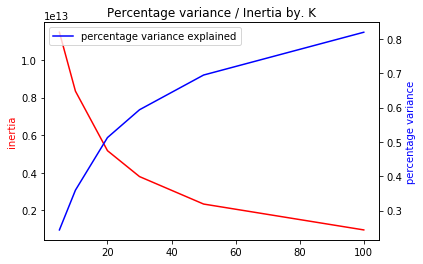

In [17]:
fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red")
ax1.set_ylabel('inertia', color="red")


ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue")
ax2.set_ylabel('percentage variance', color='blue')

plt.xlabel("K")
plt.legend()
plt.title("Percentage variance / Inertia by. K");

## K-means with 10 clusters

In [18]:
estimator_kmeans = KMeans(random_state=42, n_clusters=10)

estimator_kmeans.fit(famd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [19]:
labels = pd.DataFrame(estimator_kmeans.predict(famd))

In [20]:
labels[0].value_counts()

0    215397
2    200136
4    193883
3    191155
5    180460
7    162529
6    100776
9     80962
8     78623
1     64180
Name: 0, dtype: int64

In [21]:
centroids = estimator_kmeans.cluster_centers_
centroids

array([[ 2844.64935421,   676.51655649,   181.24250522,  2555.36969318,
         -799.08101761,  -786.03641417,   390.1746748 ,   -50.65491055,
          118.69352577,   -42.78211483],
       [ 2755.36179878,  2311.62579511,   186.47502549, -1043.15241298,
         1446.64961533,  -464.85430358, -1753.98180042,  -113.04458798,
         -360.80343134,   223.05344257],
       [ 3934.09943338,  -975.15888448, -1695.58757794,  -136.8004957 ,
         -467.86426108,   264.09841729,  -127.97636855,  -218.63099275,
         -224.62655189,    17.38579754],
       [ 2975.07949023,   292.50739677,   872.65010848, -1074.03963502,
         -954.01784075,    65.2680809 , -1427.87105952,   769.45395542,
          142.51278515,   114.5364565 ],
       [ 2635.48218558,   -53.60680193,   722.28483096, -1600.29138797,
         -756.57805887,  -935.9253718 ,  1433.22433955,   -45.96385731,
           95.01313644,  -153.34026124],
       [ 3735.97368186, -2071.08970998,   577.19122434,   300.08826799,
   

## K-means with 8 clusters

In [12]:
estimator_kmeans2 = KMeans(random_state=42, n_clusters=8)

estimator_kmeans2.fit(famd)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [13]:
labels2 = pd.DataFrame(estimator_kmeans2.predict(famd))
labels2[0].value_counts()

4    215364
6    200470
7    200178
2    200148
3    194055
1    180500
0    176562
5    100824
Name: 0, dtype: int64

In [14]:
centroids2 = estimator_kmeans2.cluster_centers_
centroids2

array([[ 2334.06374982,  2334.08514697,   272.96346139,  -752.70478264,
         1182.97334304, -1116.01070024,  -408.51041034,  -134.94336852,
         -446.28759582,    89.19250962],
       [ 3735.90850164, -2070.77960215,   577.26208958,   300.27779799,
          648.5513775 ,   -27.99906037,  -212.56781091,  -177.56461382,
         -127.37448596,    11.58989311],
       [ 2691.85762605,  1097.74407597,   627.96945265,   136.37825958,
          468.38548415,  2123.09354734,  1092.8206522 ,   700.45779294,
          -35.42594924,    49.31836503],
       [ 2634.68296902,   -52.89339735,   722.71417438, -1599.5866909 ,
         -754.9183341 ,  -936.46352766,  1433.20669796,   -45.99776939,
           94.68087564,  -152.804348  ],
       [ 2844.74805243,   676.4955361 ,   181.12030223,  2555.37413685,
         -799.22738448,  -786.28929665,   390.07205061,   -50.99785979,
          118.78002429,   -42.67802701],
       [ 3174.25461083,   439.47818117, -1315.37058796,   394.27440057,
   

In [49]:
# we select the model with 8 clusters because of better distribution 
# compute silhouette score
sklearn.metrics.silhouette_score(famd,labels2[0].ravel())

0.2386747497420425

## summarizing the clusters

In [56]:
allvar = pd.read_pickle('customer_all_variables.pkl')

In [57]:
allvar.shape

(1468101, 33)

In [58]:
allvar.reset_index(inplace=True)
allvar.head()

,UniqueID,Freq,Sex,Age,Age_Group,Hospital,HType,HRegion,Payer,Insurance_Type,...,region_Viseu,General_Service_Appointment,General_Service_Emergency,General_Service_Examination,General_Service_Others,General_Service_Surgery,General_Service_Treatment,Sex_Feminino,Sex_Masculino,Sex_Missing
0,00000f7264c27ba6fea0c837ed6aa0aa,4,Masculino,47.4,Prime Working,HCP,Large,Porto,MÉDIS,Private,...,0.0,0.2,0.2,0.60,0.0,0.00,0.0,0,1,0
1,00001e984eba85527fd3122056451279,8,Feminino,63.8,Mature Working,HCIS,Large,Lisbon,ALLIANZ,Private,...,0.0,0.3,0.0,0.70,0.0,0.00,0.0,1,0,0
2,0000219e4b37d2504fb6b8c28e24a2d4,1,Feminino,10.0,Child,ICDT,Clinic,Porto,MÉDIS,Private,...,0.0,0.5,0.0,0.50,0.0,0.00,0.0,1,0,0
3,000026c67a83fa72aec14512887bb173,2,Masculino,37.0,Prime Working,CCC,Medium,Lisbon,MÉDIS,Private,...,0.0,0.0,0.0,0.75,0.0,0.25,0.0,0,1,0
4,000028899fe7782862d40bb1b87807ee,2,Masculino,11.5,Child,HCD,Large,Lisbon,ADSE,State,...,0.0,0.0,1.0,0.00,0.0,0.00,0.0,0,1,0


In [59]:
agegroup = pd.get_dummies(allvar['Age_Group'])
allvar = allvar.join(agegroup)

In [60]:
allvar['clusterID'] = labels2
allvar.head(5)

,UniqueID,Freq,Sex,Age,Age_Group,Hospital,HType,HRegion,Payer,Insurance_Type,...,General_Service_Treatment,Sex_Feminino,Sex_Masculino,Sex_Missing,Child,Early Working,Elderly,Mature Working,Prime Working,clusterID
0,00000f7264c27ba6fea0c837ed6aa0aa,4,Masculino,47.4,Prime Working,HCP,Large,Porto,MÉDIS,Private,...,0.0,0,1,0,0,0,0,0,1,4
1,00001e984eba85527fd3122056451279,8,Feminino,63.8,Mature Working,HCIS,Large,Lisbon,ALLIANZ,Private,...,0.0,1,0,0,0,0,0,1,0,7
2,0000219e4b37d2504fb6b8c28e24a2d4,1,Feminino,10.0,Child,ICDT,Clinic,Porto,MÉDIS,Private,...,0.0,1,0,0,1,0,0,0,0,6
3,000026c67a83fa72aec14512887bb173,2,Masculino,37.0,Prime Working,CCC,Medium,Lisbon,MÉDIS,Private,...,0.0,0,1,0,0,0,0,0,1,3
4,000028899fe7782862d40bb1b87807ee,2,Masculino,11.5,Child,HCD,Large,Lisbon,ADSE,State,...,0.0,0,1,0,1,0,0,0,0,5


In [61]:
allvar.set_index(allvar.UniqueID, inplace=True)
allvar.drop('UniqueID',axis=1,inplace=True)
allvar.head(3)

,Freq,Sex,Age,Age_Group,Hospital,HType,HRegion,Payer,Insurance_Type,Specific_Service,...,General_Service_Treatment,Sex_Feminino,Sex_Masculino,Sex_Missing,Child,Early Working,Elderly,Mature Working,Prime Working,clusterID
UniqueID,,,,,,,,,,,,,,,,,,,,,
00000f7264c27ba6fea0c837ed6aa0aa,4,Masculino,47.4,Prime Working,HCP,Large,Porto,MÉDIS,Private,PATOLOGIA CLINICA,...,0.0,0,1,0,0,0,0,0,1,4
00001e984eba85527fd3122056451279,8,Feminino,63.8,Mature Working,HCIS,Large,Lisbon,ALLIANZ,Private,SERVIÇOS ESPECIAIS DERMATOLOGIA,...,0.0,1,0,0,0,0,0,1,0,7
0000219e4b37d2504fb6b8c28e24a2d4,1,Feminino,10.0,Child,ICDT,Clinic,Porto,MÉDIS,Private,SERVIÇOS ESPECIAIS OFTALMOLOGIA,...,0.0,1,0,0,1,0,0,0,0,6


In [66]:
allvar.isnull().any()

Freq                           False
Sex                            False
Age                            False
Age_Group                      False
Hospital                       False
HType                          False
HRegion                        False
Payer                          False
Insurance_Type                 False
Specific_Service               False
Category_of_Service            False
General_Service                False
Clinic                         False
Large_Hospital                 False
Medium_Hospital                False
Payer_Other                    False
Payer_Out_of_Pocket            False
Payer_Private                  False
Payer_Special_Program          False
Payer_State                    False
region_Lisbon                  False
region_Porto                   False
region_Santarem                False
region_Viseu                   False
General_Service_Appointment    False
General_Service_Emergency      False
General_Service_Examination    False
G

In [67]:
allvar.shape

(1468101, 39)

In [62]:
# save the all variable dataframe with labels
allvar.to_pickle('kmean_famd_allvariables.pkl')

In [63]:
categorical_data = allvar.select_dtypes(include = object)
categorical_data.columns.to_list()

['Sex',
 'Age_Group',
 'Hospital',
 'HType',
 'HRegion',
 'Payer',
 'Insurance_Type',
 'Specific_Service',
 'Category_of_Service',
 'General_Service']

In [64]:
def cluster_summary(cluster_id):
    cluster = allvar[allvar.clusterID==cluster_id]
    
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [68]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("clusterID").T

summary = cluster_comparison(0,1,2,3,4,5,6,7)

In [69]:
summary

clusterID,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Age,47.64,36.6336,44.7716,38.3957,37.0137,50.8201,38.4844,36.9265
Age_Group,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working,Prime Working
Category_of_Service,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,CONSULTA EXTERNA,IMAGIOLOGIA,CONSULTA EXTERNA,CONSULTA EXTERNA
Child,0.121481,0.23123,0.146417,0.175595,0.238907,0.0920713,0.13179,0.186324
Clinic,0.523193,0.0461415,0.333616,0.0320372,0.057637,0.0431516,0.903437,0.0488085
Early Working,0.108574,0.0823989,0.0884545,0.0938445,0.0835794,0.0870725,0.0965132,0.0836955
Elderly,0.254823,0.122964,0.265129,0.117869,0.141259,0.317305,0.0996009,0.10076
Freq,10.0559,8.29992,3.32624,9.49505,6.7884,5.75483,7.37903,9.90604
General_Service,Examination,Examination,Appointment,Examination,Examination,Examination,Examination,Examination
General_Service_Appointment,0.386688,0.372892,0.5719,0.36499,0.396737,0.218889,0.497325,0.363044


In [70]:
# export summary dataframe
summary.to_pickle('kmeans_famd_summary.pkl')

## Predict cluster labels for new customers

In [78]:
newdf = pd.read_pickle('newcustomers_famd.pkl')

In [79]:
newdf

,0,1,2,3,4,5,6,7,8,9
0,3493.704083,-1083.150010,2555.848215,-301.398779,-651.516177,-506.081769,1283.342501,-859.698466,9.223514,175.712914
1,3364.236027,1037.091769,-1881.462425,-1336.154218,2495.536329,-586.454201,-387.026135,16.762549,-721.973485,1796.827889
2,2824.194354,-1220.444569,-945.542649,2839.612235,-375.476303,-1702.654175,1079.500698,1282.002997,-359.078469,-1704.206258
3,2922.999820,1648.062102,251.460905,869.395276,-3037.977042,-626.908226,-841.317157,309.652343,83.170957,291.929800
4,2880.516491,-660.228193,178.164257,1003.339288,2193.131685,2180.150257,489.122437,1251.428261,1245.534972,-707.561022


In [80]:
newlabels = estimator_kmeans2.predict(newdf)

In [81]:
estimator_kmeans2.predict(newdf)

array([3, 5, 4, 4, 2], dtype=int32)